In [10]:
import os
from pathlib import Path


# add repo root to beginning of sys path to allow other modules to be found by python import machinery
import sys 
sys.path
ROOT_PATH = os.path.abspath('..')
sys.path.insert(0, ROOT_PATH)

# os instead of above can directly change cur dir path to root
# ROOT_PATH= str(Path(os.getcwd()).parents[0])
# os.chdir(ROOT_PATH)


In [6]:
from forecast.prepare_data_for_s3 import *
from forecast.create_predictor_forecast_jobs import *
from forecast.teardown_resources import *
from forecast.common import *
from forecast.dataset_and_import_jobs import *

In [7]:
# what is your forecast horizon in number time units you've selected?
FORECAST_LENGTH = 35
# What is your forecast time unit granularity?
DATASET_FREQUENCY = "D"
TIMESTAMP_FORMAT = "yyyy-MM-dd"
# We will use this same name for your Forecast Dataset Group name.
PROJECT = 'manning_ts'
DATA_VERSION = 1
bucket_name = 'aws-forecast-demo-examples'
key = "manning_ts_2015.csv"
dataset_name = f"{PROJECT}_{DATA_VERSION}"
dataset_group = f"{PROJECT}_{DATA_VERSION}"
predictor_name = f"{PROJECT}_{DATA_VERSION}_automl"
forecast_name = f"{PROJECT}_{DATA_VERSION}_automl_forecast"

# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
ts_schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

role_name = "AmazonForecast-ExecutionRole-1645141603603"
iam = boto3.client('iam')
role_arn = iam.get_role(RoleName=role_name)['Role']['Arn']

In [8]:
# load sample manning from prophet github repo and update datasets folder

#pdf = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
#pdf.to_csv(path)

#### Local parsing and loading data into S3 

In [19]:
path = f"{ROOT_PATH}/datasets/forecasting"
df, basepath = read_raw_csv(path)
df.head()

Reading data from /Users/rk1103/Documents/AWS-ML-services/datasets/forecasting/sample_manning.csv


,Unnamed: 0,ds,y
0,0,2007-12-10,9.590761
1,1,2007-12-11,8.519590
2,2,2007-12-12,8.183677
3,3,2007-12-13,8.072467
4,4,2007-12-14,7.893572


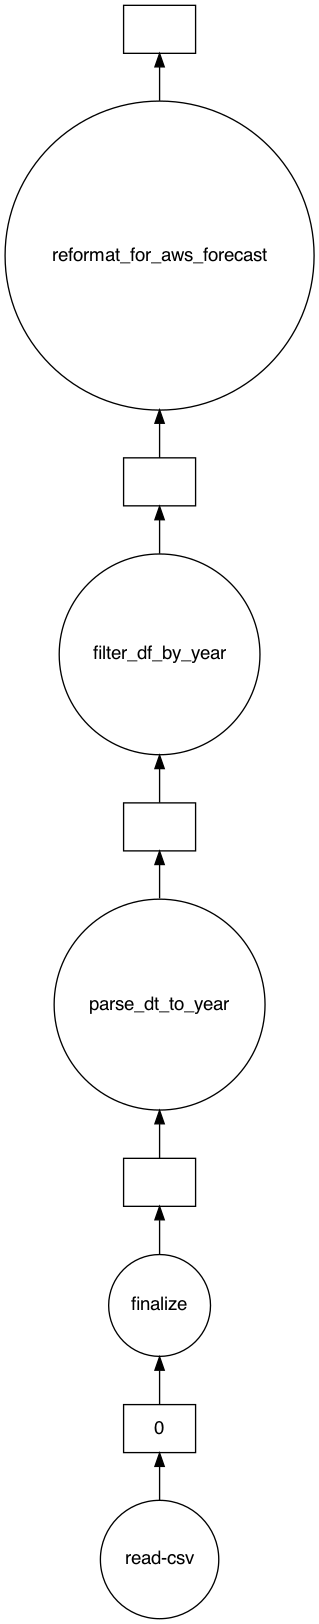

In [12]:

df_parsed = parse_dt_to_year(df)   
df_filtered = filter_df_by_year(df_parsed)   
df_renamed = reformat_for_aws_forecast(df_filtered)   
df_renamed.visualize(filename=f'{path}/example_dask_taskgraph.png')

In [13]:
df_final = df_renamed.compute()
df_final.head()

,timestamp,target_value,item_id
0,2015-01-01,7.846590,1
1,2015-01-02,8.302018,1
2,2015-01-03,8.436200,1
3,2015-01-04,8.934587,1
4,2015-01-05,8.888619,1


In [14]:
dask.array.compute(df_final.shape)[0]

(363, 3)

In [15]:
filepath = save_data_for_s3(df_final, basepath, filename=key)

/Users/rk1103/Documents/AWS-ML-services/datasets/forecasting/s3_upload/manning_ts_2015.csv


### Create AWS Forecast Job 

In [16]:

put_object_in_s3_bucket(bucket_name, filepath)

{'ResponseMetadata': {'RequestId': 'T9W78VQTA57QQ9SJ', 'HostId': 'r9DR/5uFMZuwOioaylf2pgYIA7okM86zPx2xS6v+PA4vtEmp2GWBMhUdrKMz/8PFRKHz0zmy9Vw=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'r9DR/5uFMZuwOioaylf2pgYIA7okM86zPx2xS6v+PA4vtEmp2GWBMhUdrKMz/8PFRKHz0zmy9Vw=', 'x-amz-request-id': 'T9W78VQTA57QQ9SJ', 'date': 'Wed, 04 May 2022 20:01:40 GMT', 'location': '/aws-forecast-demo-examples', 'server': 'AmazonS3', 'content-length': '0'}, 'RetryAttempts': 0}, 'Location': '/aws-forecast-demo-examples'}


#### Creating Dataset Group and Import Job in AWS Forecast

In [252]:
# Recall path to your data

dataset_arn = create_dataset(dataset_name, DATASET_FREQUENCY, ts_schema)
dataset_group_arn = create_dataset_group_with_dataset(dataset_name, dataset_arn)


In [147]:
ts_dataset_import_job_response = create_import_job(bucket_name, key, dataset_arn, role_arn)

S3 URI for your data file = s3://aws-forecast-demo-examples/manning_ts_2015.csv


In [160]:
dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']
check_job_status(dataset_import_job_arn, job_type="import_data")

Import job now complete, ready to start training


### Training and Evaluating Backtest 

In [175]:
create_predictor_response , predictor_arn = train_aws_forecast_model(predictor_name, FORECAST_LENGTH, DATASET_FREQUENCY, dataset_group_arn)
check_job_status(predictor_arn, job_type="training")

Training job complete with job status ACTIVE


#### check config of training job and execution details once complete

In [279]:

training_job_config, execution_details = get_training_job_config_and_execution_details(predictor_arn)
print(f"Training job configuration:\n\n {training_job_config}")
print("")
print(f"Model execution details:\n\n {execution_details}")

Training job configuration:

 [('ForecastHorizon', 24), ('ForecastTypes', ['0.1', '0.5', '0.9']), ('PerformAutoML', True), ('TrainingParameters', {'context_length': '1100', 'exp_kernel_weights': '0.01', 'kernel_type': 'exponential', 'prediction_length': '24', 'use_default_time_features': 'true', 'use_seasonal_model': 'true'}), ('EvaluationParameters', {'NumberOfBacktestWindows': 1, 'BackTestWindowOffset': 24}), ('InputDataConfig', {'DatasetGroupArn': 'arn:aws:forecast:us-east-1:376337229415:dataset-group/manning_ts_1'}), ('FeaturizationConfig', {'ForecastFrequency': 'D', 'Featurizations': [{'AttributeName': 'target_value', 'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling', 'FeaturizationMethodParameters': {'aggregation': 'sum', 'backfill': 'zero', 'frontfill': 'none', 'middlefill': 'zero'}}]}]}), ('PredictorExecutionDetails', {'PredictorExecutions': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/ETS', 'TestWindows': [{'TestWindowStart': datetime.datetime(2015, 12, 8, 0, 

#### Error metrics for different models tested with auto ml

In [248]:

error_metrics = evaluate_backtesting_metrics(predictor_arn)

[{'AlgorithmArn': 'arn:aws:forecast:::algorithm/NPTS', 'TestWindows': [{'EvaluationType': 'SUMMARY', 'Metrics': {'RMSE': 0.5813304989234203, 'WeightedQuantileLosses': [{'Quantile': 0.9, 'LossValue': 0.02063651665657977}, {'Quantile': 0.5, 'LossValue': 0.062278599702156975}, {'Quantile': 0.1, 'LossValue': 0.02514369892312955}], 'ErrorMetrics': [{'ForecastType': 'mean', 'WAPE': 0.05279864664804241, 'RMSE': 0.5813304989234203, 'MASE': 1.0084322939081958, 'MAPE': 0.05034810554074965}], 'AverageWeightedQuantileLoss': 0.03601960509395543}}, {'TestWindowStart': datetime.datetime(2015, 12, 8, 0, 0, tzinfo=tzlocal()), 'TestWindowEnd': datetime.datetime(2016, 1, 1, 0, 0, tzinfo=tzlocal()), 'ItemCount': 1, 'EvaluationType': 'COMPUTED', 'Metrics': {'RMSE': 0.5813304989234203, 'WeightedQuantileLosses': [{'Quantile': 0.9, 'LossValue': 0.02063651665657977}, {'Quantile': 0.5, 'LossValue': 0.062278599702156975}, {'Quantile': 0.1, 'LossValue': 0.02514369892312955}], 'ErrorMetrics': [{'ForecastType': 'me

### Forecasting and saving results

In [183]:

forecast_arn = create_forecast(forecast_name, predictor_arn)

<AxesSubplot:>

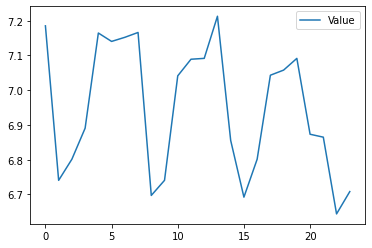

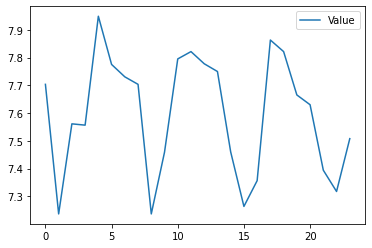

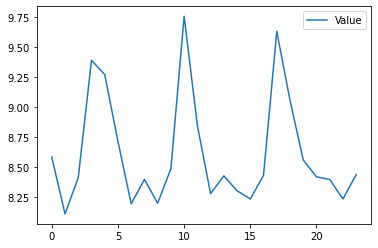

In [193]:
filters = {"item_id":"1"}
prediction_df_p10,prediction_df_p50,prediction_df_p90 = run_forecast_query_and_plot(forecast_arn, filters)

In [244]:

args = [('manning_automl_bt1_horizon24_metrics.json', error_metrics), 
        ('manning_automl_bt1_horizon24_forecastResponse.json', forecastResponse)]
               
save_results(basepath, *args)

saving to manning_automl_bt1_horizon24_metrics.json
saving to manning_automl_bt1_horizon24_forecastResponse.json


#### Cleanup resources 

In [353]:
kwargs = {'forecast':forecast_name,
'predictor':predictor_name
}
        
delete_training_forecast_resources(**kwargs)

No predictor job currently exists
No forecast job currently exists


In [354]:
delete_dataset_resources(dataset_name)

No dataset group resource exists
No dataset resource exists
